## Data Lebel Part 1
Label dataset from tobeprocess_reddit_stock_comments.csv to labelled_reddit_stock_comments.csv. This use GPT 4o to label the sentiment in batches of 50 records. However, I notice that there is a high percentage of neutral sentiment. Perhaps the raw dataset was too noisy to begin with. Further cleaning was done after this.

In [ ]:
# import os
# import csv
# import json
# import time
# import re
# import pandas as pd
# from openai import AzureOpenAI
# from dotenv import load_dotenv

# def main():
#     """
#     This script performs sentiment analysis on stock-related Reddit comments.
#     It reads data from a CSV file, uses Azure OpenAI to classify sentiment,
#     and saves the results to a new CSV with a checkpointing mechanism for resuming.
#     """
#     # Define the path to the .env file in the main directory
#     env_path = os.path.abspath(os.path.join(os.path.dirname(__file__), "..", ".env"))

#     # Load the environment variables from the specified .env file **BEFORE** creating AzureOpenAI client
#     load_dotenv(dotenv_path=env_path)

#     # Retrieve credentials from environment variables
#     azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
#     api_key = os.getenv("AZURE_OPENAI_API_KEY")
#     api_version = os.getenv("OPENAI_API_VERSION")
#     model_name = os.getenv("AZURE_OPENAI_MODEL_NAME")

#     # Ensure credentials are loaded
#     if not azure_endpoint or not api_key or not api_version or not model_name:
#         raise ValueError("Missing required environment variables. Please check your .env file.")

#     # Azure OpenAI configuration
#     client = AzureOpenAI(
#         azure_endpoint=azure_endpoint,
#         api_key=api_key,
#         api_version=api_version
#     )

#     # File paths
#     input_file = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/Crawling/reddit_stock_comments.csv"
#     output_file = "labelled_reddit_stock_comments.csv"
#     checkpoint_file = "checkpoint.txt"

#     # Read existing labelled file if it exists
#     if os.path.exists(output_file):
#         processed_df = pd.read_csv(output_file)
#         processed_ids = set(processed_df["comment_id"].astype(str))
#     else:
#         processed_df = pd.DataFrame(columns=[
#             "comment_id", "post_id", "subreddit", "comment_author", "comment_body", 
#             "comment_score", "comment_created_utc", "text", "sentiment"
#         ])
#         processed_ids = set()

#     # Read the main CSV
#     df = pd.read_csv(input_file, dtype=str)

#     # Filter rows that haven't been processed
#     df = df[~df["comment_id"].astype(str).isin(processed_ids)]

#     def analyze_sentiment(batch):
#         """
#         Sends a batch of comments to Azure OpenAI for sentiment analysis.
#         Returns parsed JSON with comment IDs and sentiments in the format:
#         [{"comment_id": <string>, "sentiment": "Positive"|"Negative"|"Neutral"}]
#         """
#         system_prompt = (
#             "You are a helpful assistant that can analyze the sentiment of user comments. "
#             "Classify each comment as Positive, Negative, or Neutral. "
#             "Return the result as valid JSON WITHOUT any formatting like a markdown code block. "
#             "Each element in the JSON array should look like: "
#             '{"comment_id": <string>, "sentiment": <"Positive"|"Negative"|"Neutral">}.'
#         )
        
#         user_prompt = [
#             f"{i+1}. Comment ID: {row['comment_id']} | Text: {row['comment_body']}"
#             for i, row in enumerate(batch)
#         ]
#         joined_comments = "\n".join(user_prompt)
        
#         messages = [
#             {"role": "system", "content": system_prompt},
#             {"role": "user", "content": f"Here are the comments:\n{joined_comments}\n"}
#         ]
        
#         try:
#             response = client.chat.completions.create(
#                 model=model_name,
#                 messages=messages,
#                 max_tokens=2000,
#                 temperature=0  # Deterministic output
#             )
            

#             if not response or not response.choices:
#                 print("Error: Empty response received from OpenAI API.")
#                 return []

#             content = response.choices[0].message.content.strip()

#             print("Raw API Response:", content)

#             content = re.sub(r"^```json\n|\n```$", "", content.strip())

#             print("Cleaned JSON Response:", content)

#             # Attempt to parse JSON
#             results = json.loads(content)
#             return results
#         except json.JSONDecodeError as parse_error:
#             print(f"JSON Decode Error: {parse_error}. Response received: {content}")
#             return []
#         except Exception as e:
#             print(f"Error calling Azure OpenAI API: {e}")
#             return []
    
#     # Process in batches
#     batch_size = 50
    
#     for i in range(0, len(df), batch_size):
#         batch = df.iloc[i:i+batch_size].to_dict(orient="records")
#         try:
#             results = analyze_sentiment(batch)
#             if not results:
#                 print(f"Skipping batch {i//batch_size + 1} due to invalid or empty response.")
#                 continue
            
#             for result in results:
#                 comment_id = str(result.get("comment_id"))
#                 sentiment = result.get("sentiment")
#                 df.loc[df["comment_id"] == comment_id, "sentiment"] = sentiment
            
#             df.iloc[i:i+batch_size].to_csv(
#                 output_file, 
#                 mode='a', 
#                 index=False, 
#                 header=not os.path.exists(output_file)
#             )
            
#             with open(checkpoint_file, "w") as f:
#                 f.write(str(i + batch_size))
            
#             print(f"Processed batch {i//batch_size + 1}")
#             time.sleep(1)  # Avoid rate limiting
#         except Exception as e:
#             print(f"Error processing batch {i//batch_size + 1}: {str(e)}")
#             break
    
#     print("Sentiment analysis completed.")

# if __name__ == "__main__":
#     main()

## Data Cleaning
After that I clean the dataset and introduced metrics as shown below. This will set a foundation to the dataset before we process further. Should have done earlier on. But I already have spent quite abit on the GPT labelling so didn't want to waste the labelling.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import numpy as np

posts_path = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/Crawling/NVIDIA_reddit_stock_posts.csv"
comments_path = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/Crawling/NVIDIA_reddit_stock_comments.csv"

df_posts = pd.read_csv(posts_path)
df_comments = pd.read_csv(comments_path)

In [10]:
print("=== INITIAL DATA STATISTICS ===")
print(f"Number of posts: {len(df_posts)}")
print(f"Number of comments: {len(df_comments)}")

num_unique_post_authors = df_posts['author'].nunique() if 'author' in df_posts.columns else 0
num_unique_comment_authors = df_comments['comment_author'].nunique() if 'comment_author' in df_comments.columns else 0
print(f"Number of unique authors in posts: {num_unique_post_authors}")
print(f"Number of unique authors in comments: {num_unique_comment_authors}")

# We'll assume each post has a unique 'post_id', and each comment has a unique 'comment_id'
num_unique_posts = df_posts['post_id'].nunique() if 'post_id' in df_posts.columns else 0
num_unique_comments = df_comments['comment_id'].nunique() if 'comment_id' in df_comments.columns else 0
print(f"Number of unique posts: {num_unique_posts}")
print(f"Number of unique comments: {num_unique_comments}")

# Average number of comments per post (if we have post_id in comments to group by)
if 'post_id' in df_comments.columns:
    avg_comments_per_post = df_comments.groupby('post_id')['comment_id'].nunique().mean()
    print(f"Average number of comments per post: {avg_comments_per_post:.2f}")
print("================================\n")

=== INITIAL DATA STATISTICS ===
Number of posts: 919
Number of comments: 31729
Number of unique authors in posts: 509
Number of unique authors in comments: 6480
Number of unique posts: 919
Number of unique comments: 31729
Average number of comments per post: 37.59



Generating Word Cloud for POSTS (Before Cleaning)...


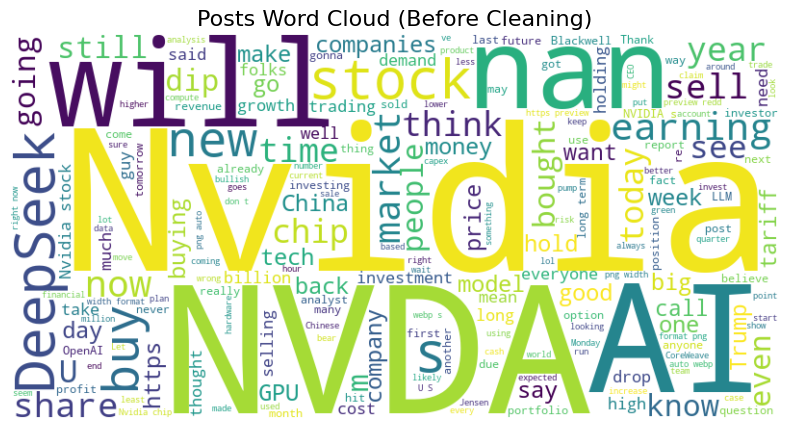

Generating Word Cloud for COMMENTS (Before Cleaning)...


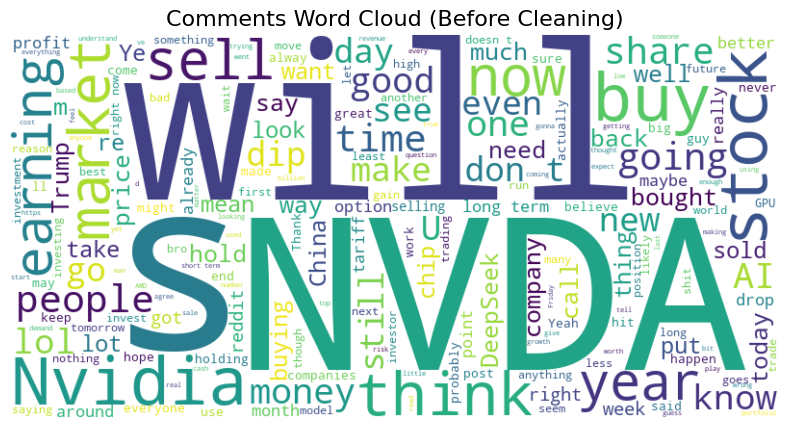

In [11]:
def create_wordcloud(text_series, title="Word Cloud"):
    """
    Generate and plot a word cloud from a pandas Series of text entries.
    """
    # Combine all text into one string
    text = " ".join(str(t) for t in text_series.dropna())
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()


print("Generating Word Cloud for POSTS (Before Cleaning)...")
create_wordcloud(df_posts['title'].astype(str) + " " + df_posts.get('selftext', "").astype(str),
                 title="Posts Word Cloud (Before Cleaning)")

print("Generating Word Cloud for COMMENTS (Before Cleaning)...")
create_wordcloud(df_comments['comment_body'].astype(str),
                 title="Comments Word Cloud (Before Cleaning)")

In [12]:
# Remove duplicates by (title, selftext, author) if they exist
df_posts.drop_duplicates(subset=['title', 'selftext', 'author'], keep='first', inplace=True)

# You could also remove posts with empty title/selftext if needed:
df_posts = df_posts[(df_posts['title'].notnull()) & (df_posts['title'].str.strip() != "")]

# Save cleaned posts into a new CSV
cleaned_posts_path = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/NVIDIA_clean_reddit_stock_posts.csv"
df_posts.to_csv(cleaned_posts_path, index=False)
print(f"Cleaned posts saved to: {cleaned_posts_path}")

Cleaned posts saved to: /Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/NVIDIA_clean_reddit_stock_posts.csv


In [13]:
if 'post_id' in df_comments.columns and 'post_id' in df_posts.columns:
    valid_post_ids = set(df_posts['post_id'].unique())
    df_comments = df_comments[df_comments['post_id'].isin(valid_post_ids)]

# Remove duplicates based on comment_author + comment_body
df_comments.drop_duplicates(subset=['comment_author', 'comment_body'], keep='first', inplace=True)

# Define helper functions to filter comments
def special_char_ratio(text):
    """
    Returns the ratio of non-alphanumeric characters (excluding whitespace) to total length of text.
    """
    if not isinstance(text, str) or len(text) == 0:
        return 0
    special_chars = re.findall(r'[^A-Za-z0-9\s]', text)
    return len(special_chars) / len(text)

def word_count(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

def unique_word_count(text):
    if not isinstance(text, str):
        return 0
    return len(set(text.split()))

# Create columns (optional, for debugging/analysis)
df_comments['special_char_ratio'] = df_comments['comment_body'].apply(special_char_ratio)
df_comments['word_count'] = df_comments['comment_body'].apply(word_count)
df_comments['unique_word_count'] = df_comments['comment_body'].apply(unique_word_count)

# Filter comments:
#   1) Must have >= 3 words
#   2) Must have a special_char_ratio < 0.5 (example threshold)
#   3) Must have at least 2 unique words
df_comments = df_comments[
    (df_comments['word_count'] >= 3) &
    (df_comments['special_char_ratio'] < 0.5) &
    (df_comments['unique_word_count'] >= 2)
]

=== AFTER CLEANING STATISTICS ===
Number of cleaned posts: 910
Number of cleaned comments: 28687
Average number of comments per post (cleaned): 34.48

Generating Word Cloud for POSTS (After Cleaning)...


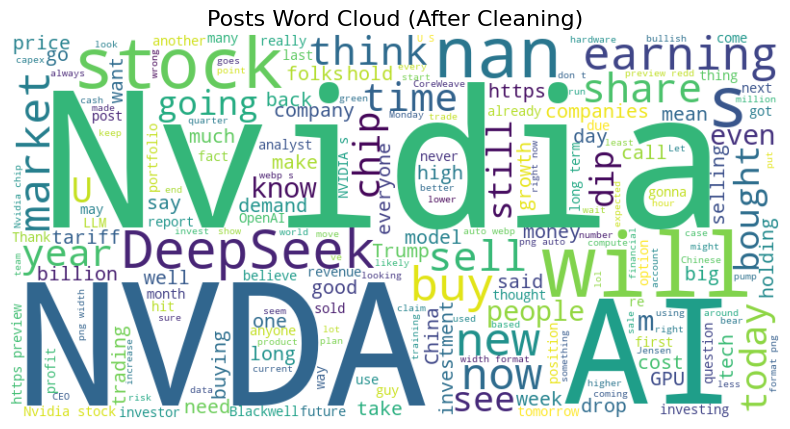

Generating Word Cloud for COMMENTS (After Cleaning)...


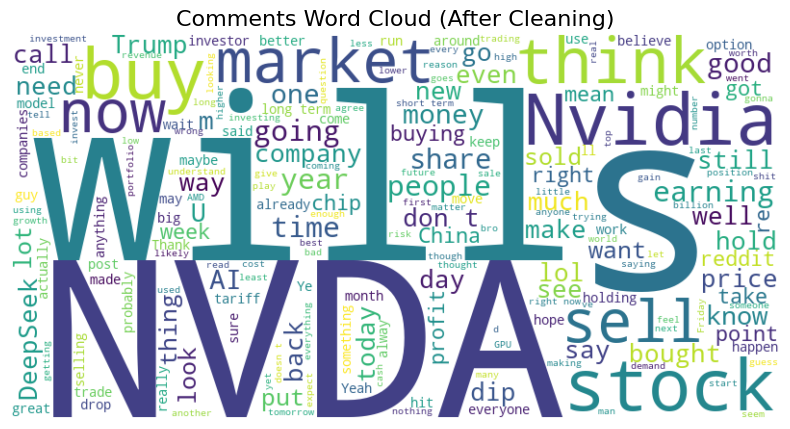

Cleaned comments saved to: /Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/NVIDIA_clean_reddit_stock_comments.csv


In [14]:
print("=== AFTER CLEANING STATISTICS ===")
print(f"Number of cleaned posts: {len(df_posts)}")
print(f"Number of cleaned comments: {len(df_comments)}")
if 'post_id' in df_comments.columns:
    avg_comments_per_post_cleaned = df_comments.groupby('post_id')['comment_body'].size().mean()
    print(f"Average number of comments per post (cleaned): {avg_comments_per_post_cleaned:.2f}")
print("================================\n")

# Word Cloud AFTER cleaning
print("Generating Word Cloud for POSTS (After Cleaning)...")
create_wordcloud(df_posts['title'].astype(str) + " " + df_posts.get('selftext', "").astype(str),
                 title="Posts Word Cloud (After Cleaning)")

print("Generating Word Cloud for COMMENTS (After Cleaning)...")
create_wordcloud(df_comments['comment_body'].astype(str),
                 title="Comments Word Cloud (After Cleaning)")

# (Optionally) Save cleaned comments if desired
cleaned_comments_path = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/NVIDIA_clean_reddit_stock_comments.csv"
df_comments.to_csv(cleaned_comments_path, index=False)
print(f"Cleaned comments saved to: {cleaned_comments_path}")


## Combine labelled sentiment to cleaned dataset
This will do a joint to move the labelled sentiment to the cleaned dataset.

In [8]:
import pandas as pd

labelled_file = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/labelled_reddit_stock_comments.csv"
clean_file = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/clean_reddit_stock_comments.csv"
output_file = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/clean_reddit_stock_comments.csv"

# Load the datasets
df_labelled = pd.read_csv(labelled_file)
df_clean = pd.read_csv(clean_file)

# Perform the join on 'comment_id'
df_merged = df_clean.merge(df_labelled[['comment_id', 'sentiment']], on='comment_id', how='left')

# Save the merged dataframe to a new CSV file
df_merged.to_csv(output_file, index=False)

print(f"Merged file saved at: {output_file}")


Merged file saved at: /Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/clean_reddit_stock_comments.csv


## Further labelling of sentiment of clean dataset

In [10]:
import os
import csv
import json
import time
import re
import pandas as pd
from openai import AzureOpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv("../.env")

# Retrieve credentials from environment variables
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_key = os.getenv("AZURE_OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
model_name = os.getenv("AZURE_OPENAI_MODEL_NAME")

# Ensure credentials are loaded
if not azure_endpoint or not api_key or not api_version or not model_name:
    raise ValueError("Missing required environment variables. Please check your .env file.")

# Azure OpenAI configuration
client = AzureOpenAI(
    azure_endpoint=azure_endpoint,
    api_key=api_key,
    api_version=api_version
)

# File path
file_path = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/clean_reddit_stock_comments.csv"

# Read the CSV file
df = pd.read_csv(file_path, dtype=str)

# Filter rows where sentiment is missing
df_missing_sentiment = df[df["sentiment"].isna()]

if df_missing_sentiment.empty:
    print("No missing sentiment data to process.")
else:
    def analyze_sentiment(batch):
        """
        Sends a batch of comments to Azure OpenAI for sentiment analysis.
        Returns parsed JSON with comment IDs and sentiments.
        """
        system_prompt = (
            "You are a helpful assistant that analyzes sentiment in Reddit stock comments. "
            "Classify each comment as towards the stock as Positive, Negative, or Neutral. "
            "Return the result as valid JSON without any markdown formatting. "
            "Each element in the JSON array should look like: "
            '{"comment_id": <string>, "sentiment": <"Positive"|"Negative"|"Neutral">}.'
        )
        
        user_prompt = [
            f"{i+1}. Comment ID: {row['comment_id']} | Text: {row['comment_body']}"
            for i, row in enumerate(batch)
        ]
        joined_comments = "\n".join(user_prompt)
        
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Here are the comments:\n{joined_comments}\n"}
        ]
        
        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=messages,
                max_tokens=2000,
                temperature=0
            )
            
            if not response or not response.choices:
                print("Error: Empty response received from OpenAI API.")
                return []

            content = response.choices[0].message.content.strip()
            
            # Remove markdown formatting
            content = re.sub(r"^```json\n|\n```$", "", content.strip())
            
            # Parse JSON
            results = json.loads(content)
            return results
        except json.JSONDecodeError as parse_error:
            print(f"JSON Decode Error: {parse_error}. Response received: {content}")
            return []
        except Exception as e:
            print(f"Error calling Azure OpenAI API: {e}")
            return []
    
    # Process in batches
    batch_size = 50
    
    for i in range(0, len(df_missing_sentiment), batch_size):
        batch = df_missing_sentiment.iloc[i:i+batch_size].to_dict(orient="records")
        try:
            results = analyze_sentiment(batch)
            if not results:
                print(f"Skipping batch {i//batch_size + 1} due to invalid or empty response.")
                continue
            
            for result in results:
                comment_id = str(result.get("comment_id"))
                sentiment = result.get("sentiment")
                df.loc[df["comment_id"] == comment_id, "sentiment"] = sentiment
            
            # Save updated CSV
            df.to_csv(file_path, index=False)
            
            print(f"Processed batch {i//batch_size + 1}")
            time.sleep(1)  # Avoid rate limiting
        except Exception as e:
            print(f"Error processing batch {i//batch_size + 1}: {str(e)}")
            break
    
    print("Sentiment analysis completed.")


Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10


KeyboardInterrupt: 

In [ ]:
import os
import csv
import json
import time
import re
import pandas as pd
from openai import AzureOpenAI
from dotenv import load_dotenv

# Load environment variables
load_dotenv("../.env")

# Retrieve credentials from environment variables
azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")
api_key = os.getenv("AZURE_OPENAI_API_KEY")
api_version = os.getenv("OPENAI_API_VERSION")
model_name = os.getenv("AZURE_OPENAI_MODEL_NAME")

# Ensure credentials are loaded
if not azure_endpoint or not api_key or not api_version or not model_name:
    raise ValueError("Missing required environment variables. Please check your .env file.")

# Azure OpenAI configuration
client = AzureOpenAI(
    azure_endpoint=azure_endpoint,
    api_key=api_key,
    api_version=api_version
)

# File path
file_path = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/clean_reddit_stock_comments.csv"

# Read the CSV file
df = pd.read_csv(file_path, dtype=str)

# Convert unique_word_count to numeric so we can sort properly
df["unique_word_count"] = pd.to_numeric(df["unique_word_count"], errors="coerce")

# Filter rows where sentiment is missing
df_missing_sentiment = df[df["sentiment"].isna()]

if df_missing_sentiment.empty:
    print("No missing sentiment data to process.")
else:
    # Sort rows with missing sentiment by unique_word_count in descending order
    df_missing_sentiment = df_missing_sentiment.sort_values(by="unique_word_count", ascending=False)

    def analyze_sentiment(batch):
        """
        Sends a batch of comments to Azure OpenAI for sentiment analysis.
        Returns parsed JSON with comment IDs and sentiments.
        """
        system_prompt = (
            "You are a helpful assistant that analyzes sentiment in Reddit stock comments. "
            "Classify each comment as towards the stock as Positive, Negative, or Neutral. "
            "Return the result as valid JSON without any markdown formatting. "
            "Each element in the JSON array should look like: "
            '{"comment_id": <string>, "sentiment": <"Positive"|"Negative"|"Neutral">}.'
        )
        
        user_prompt = [
            f"{i+1}. Comment ID: {row['comment_id']} | Text: {row['comment_body']}"
            for i, row in enumerate(batch)
        ]
        joined_comments = "\n".join(user_prompt)
        
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": f"Here are the comments:\n{joined_comments}\n"}
        ]
        
        try:
            response = client.chat.completions.create(
                model=model_name,
                messages=messages,
                max_tokens=2000,
                temperature=0
            )
            
            if not response or not response.choices:
                print("Error: Empty response received from OpenAI API.")
                return []

            content = response.choices[0].message.content.strip()
            
            # Remove markdown formatting
            content = re.sub(r"^```json\n|\n```$", "", content.strip())
            
            # Parse JSON
            results = json.loads(content)
            return results
        except json.JSONDecodeError as parse_error:
            print(f"JSON Decode Error: {parse_error}. Response received: {content}")
            return []
        except Exception as e:
            print(f"Error calling Azure OpenAI API: {e}")
            return []
    
    # Process in batches
    batch_size = 50
    
    # We'll reindex df_missing_sentiment but keep original index in case we need it
    df_missing_sentiment = df_missing_sentiment.reset_index(drop=True)

    for i in range(0, len(df_missing_sentiment), batch_size):
        batch = df_missing_sentiment.iloc[i:i+batch_size].to_dict(orient="records")
        try:
            results = analyze_sentiment(batch)
            if not results:
                print(f"Skipping batch {i//batch_size + 1} due to invalid or empty response.")
                continue
            
            for result in results:
                comment_id = str(result.get("comment_id"))
                sentiment = result.get("sentiment")
                df.loc[df["comment_id"] == comment_id, "sentiment"] = sentiment
            
            # Save updated CSV
            df.to_csv(file_path, index=False)
            
            print(f"Processed batch {i//batch_size + 1}")
            time.sleep(1)  # Avoid rate limiting
        except Exception as e:
            print(f"Error processing batch {i//batch_size + 1}: {str(e)}")
            break
    
    print("Sentiment analysis completed.")


## Rule Based Approach

In [1]:
pip install vaderSentiment

Note: you may need to restart the kernel to use updated packages.


In [16]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Specify your file path
FILE_PATH = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/NVIDIA_clean_reddit_stock_comments.csv"

# Read CSV into a pandas DataFrame
df = pd.read_csv(FILE_PATH)

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to classify sentiment based on VADER's compound score
def classify_sentiment(text):
    scores = analyzer.polarity_scores(str(text))
    compound_score = scores["compound"]
    if compound_score >= 0.05:
        return "Positive"
    elif compound_score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

# Iterate over rows and fill in missing sentiment
for index, row in df.iterrows():
    # Check if 'sentiment' is null or empty
    if pd.isnull(row["sentiment"]) or row["sentiment"] == "":
        df.at[index, "sentiment"] = classify_sentiment(row["text"])

# (Optional) Save to a new CSV file 
# so you don’t overwrite the original unless you want to
OUTPUT_PATH = "/Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/NVIDIA_clean_reddit_stock_comments_with_vader_sentiment.csv"
df.to_csv(OUTPUT_PATH, index=False)

print(f"Updated sentiment saved to: {OUTPUT_PATH}")


/var/folders/d9/99zh55td5557wrk09bgvss_w0000gn/T/ipykernel_4437/1511609837.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Positive' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, "sentiment"] = classify_sentiment(row["text"])


Updated sentiment saved to: /Users/nicholaswong/Desktop/Github/Information-Retrieval-on-Stocks/PreProcessing/NVIDIA_clean_reddit_stock_comments_with_vader_sentiment.csv
